In [1]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Agents

In [2]:
class Market:
    def __init__(self, price=1, history=dict()):
        self.price = price # Текущая цена
        self.history = history # JSON-подобный документ с полной историей
        self.step = step # Текущий шаг (временной интервал)



class Seller(mesa.Agent):

    def __init__(self, model):
        super().__init__(model)
        self.reserve = 0
        self.produce = 1
        self.sold_prev = 0
        self.sold_cur = 0
        self.price = 60
        self.price_prev = 50
        self.days_with_no_demand = 0
        self.buyers_want_home_prev = 0

    def product(self, buyers_want_home=0):
        self.reserve += self.produce
        if buyers_want_home > self.buyers_want_home_prev:
            self.produce += min([buyers_want_home, 5]) - self.days_with_no_demand
            self.buyers_want_home_prev = buyers_want_home
        else:
            self.produce -= self.days_with_no_demand
            self.buyers_want_home_prev = buyers_want_home
        
        if self.price < self.price_prev and self.sold_cur > self.sold_prev:
            self.price_prev = self.price
            self.price += 5
        elif self.price > self.price_prev and self.sold_cur < self.sold_prev:
            self.price_prev = self.price
            self.price -= 5
        else:
            self.price_prev = self.price
            self.price += 1


        if self.produce<0:
            self.produce = 0
        if buyers_want_home == 0:
            self.days_with_no_demand +=1
        if buyers_want_home > 0:
            self.days_with_no_demand = 0
        
        self.sold_prev = self.sold_cur
        self.sold_cur = 0
        
    def house_bought(self):
        self.reserve -= 1
        self.sold_cur += 1
    
    def calc_elasticity(self):
        try: 
            e = ((self.sold_cur - self.sold_prev)/(self.sold_cur + self.sold_prev))/((self.price - self.price_prev)/(self.price + self.price_prev))
        except ZeroDivisionError:
            e = -1
        return e


         
class Buyer(mesa.Agent):

    def __init__(self, model):
        super().__init__(model)
        self.n_children = 0
        self.wage = np.random.random() * 10
        self.wealth = np.random.random() * 25 - 10
        self.will_to_buy = 0
        self.n_of_houses = 0

    def change_state(self):
       self.n_children += np.random.choice(a=[0,1], p=[0.99,0.01])
       self.wealth += self.wage
       self.will_to_buy += (self.n_children + 1) / (self.n_of_houses + 1)
    
    def buy(self):
        seller = self.model.agents_by_type[Seller][0]
        if ((self.wealth - (20 - self.will_to_buy)*seller.price) > 1) and (self.wealth > seller.price):
            if seller.reserve > 2 and seller.sold_cur < 10:
                self.wealth -= seller.price
                self.will_to_buy -= 100
                self.n_of_houses += 1
                seller.house_bought() # Change seller's reserves
            else:
                self.model.buyers_want_home += 1
    
    def __str__(self):
        return 'buyer'


class Government(mesa.Agent):

    def __init__(self, model):
        super().__init__(model)

# World

In [3]:
class WorldModel(mesa.Model):
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        # Create agents
        Buyer.create_agents(model=self, n=n)
        Seller.create_agents(model=self, n=1)
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "homes": compute_homes,
                "demand": store_buyers_want_home,
                "price": store_price,
                "reserve": store_reserve,
                "produce": store_product,
                "sold": store_sold
            }
        )
        self.buyers_want_home = 0
    
    def step(self):
        self.buyers_want_home = 0
        self.agents_by_type[Buyer].do("change_state")
        self.agents_by_type[Buyer].do("buy")
        self.agents_by_type[Seller].do("product", buyers_want_home=self.buyers_want_home)
        self.datacollector.collect(self)
    
    def __str__(self):
        return 'Current world state (settings)'

def compute_homes(model):
    agent_homes = [agent.n_of_houses for agent in model.agents_by_type[Buyer]]
    return sum(agent_homes)

def store_buyers_want_home(model):
    return model.buyers_want_home

def store_price(model):
    return model.agents_by_type[Seller][0].price

def store_reserve(model):
    return model.agents_by_type[Seller][0].reserve

def store_product(model):
    return model.agents_by_type[Seller][0].produce

def store_sold(model):
    return model.agents_by_type[Seller][0].sold_prev

# Simmulation

In [4]:
model = WorldModel(200)
for _ in range(100):
    model.step()

In [5]:
model.datacollector.get_model_vars_dataframe()

,homes,demand,price,reserve,produce,sold
0,0,0,61,1,1,0
1,0,0,62,2,0,0
2,0,0,63,2,0,0
3,0,0,64,2,0,0
4,0,0,65,2,0,0
...,...,...,...,...,...,...
95,207,0,66,10,5,2
96,209,0,67,13,4,2
97,210,0,62,16,2,1
98,213,0,67,15,0,3


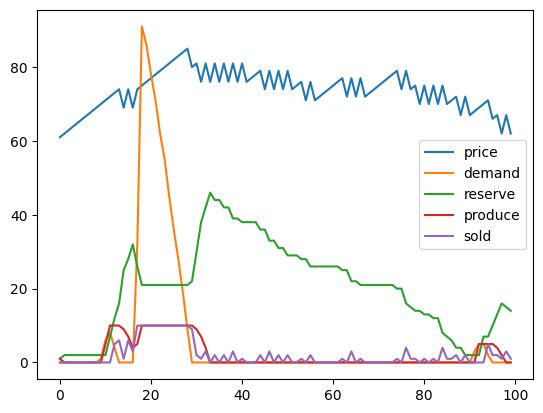

In [6]:
plt.plot(model.datacollector.get_model_vars_dataframe()[['price', 'demand', 'reserve', 'produce', 'sold']])
plt.legend(['price', 'demand', 'reserve', 'produce', 'sold'])

In [93]:
np.random.choice(a=[0,1,2], p=[0.8,0.18,0.02])

np.int64(0)